In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

In [2]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import  metrics 
from sklearn.model_selection import cross_validate, GridSearchCV

In [3]:
import lightgbm as lgb

In [4]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc


In [5]:
trainset = pd.read_csv('Data\credit_card_default_train.csv', index_col='Client_ID' )

In [6]:
testset = pd.read_csv('Data\credit_card_default_test.csv', index_col='Client_ID' )

### Data Preprocessing

In [7]:
trainset['Balance_Limit_V1'] = trainset['Balance_Limit_V1'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)
testset['Balance_Limit_V1'] = testset['Balance_Limit_V1'].replace({'K': '*1e3', 'M': '*1e6'}, regex=True).map(pd.eval).astype(int)

In [101]:
target = 'NEXT_MONTH_DEFAULT'
IDcol = 'Client_ID'
predictors = [x for x in trainset.columns if x not in [target, IDcol]]
cate_features_name = ["Gender","EDUCATION_STATUS","MARITAL_STATUS","AGE",'PAY_JULY','PAY_AUG','PAY_SEP','PAY_OCT','PAY_NOV','PAY_DEC']

In [100]:
Pay = ['PAY_JULY','PAY_AUG','PAY_SEP','PAY_OCT','PAY_NOV','PAY_DEC']

In [102]:
for item in cate_features_name:
    trainset[item] = trainset[item].astype("category").cat.codes +1

In [129]:
for item in cate_features_name:
    testset[item] = testset[item].astype("category").cat.codes +1

In [103]:
train_all, test_all = train_test_split(trainset, test_size=0.30, random_state=42)

LGBM Classifier

In [104]:
def f1score(m, train, test): 
    predictions_lgbm_01 = np.where(m.predict(train[predictors]) > 0.5, 1, 0)
    predictions_lgbm_02 = np.where(m.predict(test[predictors]) > 0.5, 1, 0)
    return (f1_score(train[target],predictions_lgbm_01),f1_score(test[target],predictions_lgbm_02))

In [ ]:
lg = lgb.LGBMClassifier(silent=False)
param_dist = {"max_depth": [25,50, 75],
              "learning_rate" : [0.01,0.05,0.1],
              "num_leaves": [300,900,1200],
              "n_estimators": [200]
             }

grid_search = GridSearchCV(lg, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="roc_auc", verbose=5)
grid_search.fit(train,y_train)
grid_search.best_estimator_

d_train = lgb.Dataset(train, label=y_train)

In [105]:
d_train = lgb.Dataset(train_all[predictors], label=train_all[target], feature_name = predictors, categorical_feature = cate_features_name, free_raw_data=False)

In [112]:
params = {'boosting_type': 'gbdt',
          'max_depth' : 10,
          'objective': 'binary',
          'nthread': 4,
          'num_leaves': 30,
          'learning_rate': 0.5,
          'min_data_in_lead': 10,
          'metric' : 'binary_error'
          }

In [113]:
model2 = lgb.train(params, d_train)

In [114]:
f1score(model2, train_all, test_all)

(0.8353778585491443, 0.4388349514563107)

In [115]:
predictions_lgbm_02 = np.where(model2.predict(test_all[predictors]) > 0.5, 1, 0)

<Figure size 432x288 with 0 Axes>

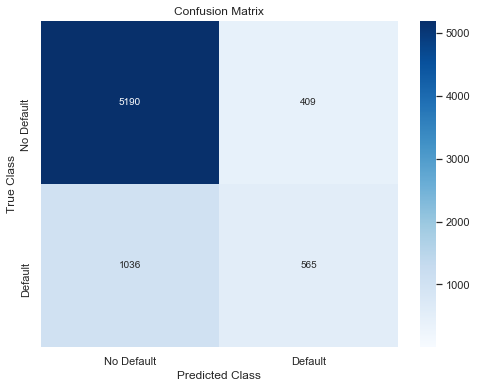

In [116]:
#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(test_all[target], predictions_lgbm_02)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [132]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
color = sns.color_palette()
import gc
import warnings
import time
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score


In [126]:
X = train_all[predictors]
y = label=train_all[target]
X_pred = testset

In [120]:
folds = StratifiedKFold(n_splits=5,random_state=6)
oof_preds = np.zeros(X.shape[0])
sub_preds = np.zeros(X_pred.shape[0])

In [141]:
start = time.time()
valid_score = 0
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
    trn_x, trn_y = X.iloc[trn_idx], y[trn_idx]
    val_x, val_y = X.iloc[val_idx], y[val_idx]    
    
    train_data = lgb.Dataset(data=trn_x, label=trn_y,categorical_feature=cate_features_name)
    valid_data = lgb.Dataset(data=val_x, label=val_y)
    
    param = {'application':'binary','num_iterations':4000, 'learning_rate':0.05, 'num_leaves':24, 'feature_fraction':0.8, 'bagging_fraction':0.9,
             'lambda_l1':0.1, 'lambda_l2':0.1, 'min_split_gain':0.01, 'early_stopping_round':100, 'max_depth':7, 'min_child_weight':40, 'metric':'auc'}

    lgb_es_model = lgb.train(param, train_data, valid_sets=[train_data, valid_data], verbose_eval=100, categorical_feature=cate_features_name) 
    
    oof_preds[val_idx] = lgb_es_model.predict(val_x, num_iteration=lgb_es_model.best_iteration)
    sub_preds = sub_preds + lgb_es_model.predict(X_pred, num_iteration=lgb_es_model.best_iteration) / folds.n_splits
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
    valid_score += roc_auc_score(val_y, oof_preds[val_idx])

print('valid score:', str(round(valid_score/folds.n_splits,4)))

end = time.time()
print('training time:', str(round((end - start)/60)), 'mins')

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.830305	valid_1's auc: 0.772148
Early stopping, best iteration is:
[72]	training's auc: 0.8212	valid_1's auc: 0.77266
Fold  1 AUC : 0.772660
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.826898	valid_1's auc: 0.78547
Early stopping, best iteration is:
[56]	training's auc: 0.814362	valid_1's auc: 0.786443
Fold  2 AUC : 0.786443
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.829911	valid_1's auc: 0.771993
[200]	training's auc: 0.847604	valid_1's auc: 0.770886
Early stopping, best iteration is:
[131]	training's auc: 0.836882	valid_1's auc: 0.772522
Fold  3 AUC : 0.772522
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.829065	valid_1's auc: 0.784027
Early stopping, best iteration is:
[57]	training's auc: 0.816384	valid_1's auc: 0.784835
Fold  4 AUC : 0.784835
Training until validation scores

In [143]:
predictions_lgbm_02 = np.where(lgb_es_model.predict(test_all[predictors]) > 0.5, 1, 0)

In [145]:
f1score(lgb_es_model, train_all, test_all)

(0.47067213407024433, 0.4600504625735912)

<Figure size 432x288 with 0 Axes>

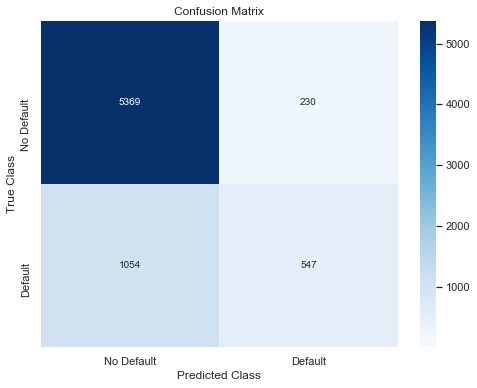

In [144]:
#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(test_all[target], predictions_lgbm_02)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()